## РК2 ММО Макаров Д.А. ИУ5-21М
## Задача 1. Классификация текстов на основе методов наивного Байеса.
## Задание
- Необходимо решить задачу классификации текстов на основе любого выбранного датасета. Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

- Необходимо сформировать признаки на основе CountVectorizer или TfidfVectorizer.

- В качестве классификаторов необходимо использовать два классификатора, не относящихся к наивным Байесовским методам (например, LogisticRegression, LinearSVC), а также Multinomial Naive Bayes (MNB), Complement Naive Bayes (CNB), Bernoulli Naive Bayes.

- Для каждого метода необходимо оценить качество классификации с помощью хотя бы двух метрик качества классификации (например, Accuracy, ROC-AUC).

- Сделать выводы о том, какой классификатор осуществляет более качественную классификацию на выбранном наборе данных.
## Выполнение


In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Загрузка данных
text = pd.read_csv("netflix_titles.csv")
text.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [3]:
text.shape

(6234, 12)

In [4]:
text['type'].unique()

array(['Movie', 'TV Show'], dtype=object)

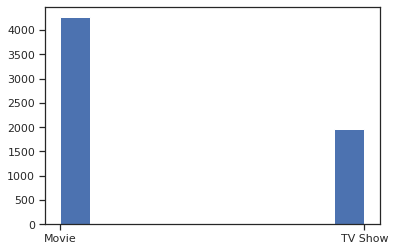

In [5]:
plt.hist(text['type'])
plt.show()

Будем использовать функцию balanced_accuracy_score вместо функции accuracy_score

In [6]:
# Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки
vocab_list = text['description'].tolist()
vocab_list[1:10]

['Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of "Sex on Fire" in his comedy show.',
 'With the help of three human allies, the Autobots once again protect Earth from the onslaught of the Decepticons and their leader, Megatron.',
 'When a prison ship crash unleashes hundreds of Decepticons on Earth, Bumblebee leads a new Autobot force to protect humankind.',
 'When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity.',
 'A young journalist is forced into a life of crime to save his father and family in this series based on the novel by Miguel Sáez Carral.',
 'In a dystopian future, an insurance adjuster for a tech company investigates a robot killed for violating protocol and discovers a global conspiracy.',
 'Fabrizio Copano takes audience participation to the next level in this stand-up set while reflecting on sperm banks, family 

In [7]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 16411


In [8]:
tfidfv = TfidfVectorizer(ngram_range=(1,3))
tfidf_ngram_features = tfidfv.fit_transform(vocab_list)
tfidf_ngram_features

<6234x217200 sparse matrix of type '<class 'numpy.float64'>'
	with 399657 stored elements in Compressed Sparse Row format>

##### Проверим классификаторы метод К соседей и LogisticRegression.
##### В качестве наивных Байесовских используем методы Complement Naive Bayes (CNB) и Bernoulli Naive Bayes.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(text['description'], text['type'], test_size=0.5, random_state=1)

##### Используем метрики качества balanced_accuracy и матрицу ошибок.

In [10]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = balanced_accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))
    


In [11]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    print_accuracy_score_for_classes(y_test, y_pred)
    
    # Матрица ошибок
    fig, ax = plt.subplots( figsize=(15,5))
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)


/home/denis/ml/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Movie 	 0.9967012252591895
TV Show 	 0.09045226130653267


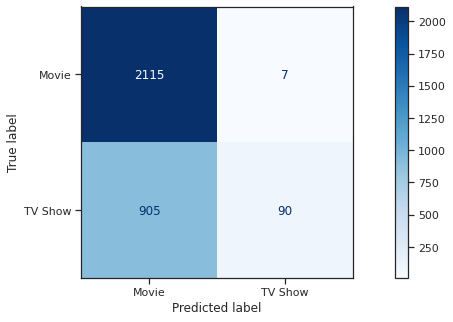

In [12]:
sentiment(TfidfVectorizer(ngram_range=(1,3)), LogisticRegression())

Для метода К соседей найдем в цикле лучшее кол-во соседей

/home/denis/ml/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Movie 	 0.9208294062205467
TV Show 	 0.22110552763819097


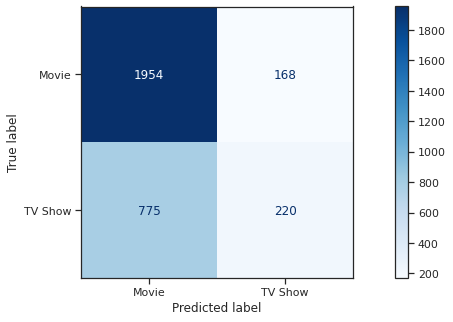

In [14]:
# 4 соседа
sentiment(TfidfVectorizer(ngram_range=(1,4)), KNeighborsClassifier(n_neighbors=4))

/home/denis/ml/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Movie 	 0.9736098020735156
TV Show 	 0.19698492462311556


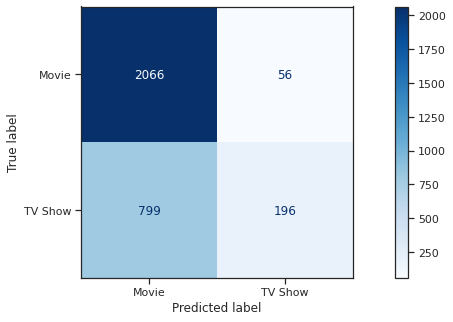

In [15]:
sentiment(TfidfVectorizer(), ComplementNB())

/home/denis/ml/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Movie 	 0.9863336475023563
TV Show 	 0.16381909547738693


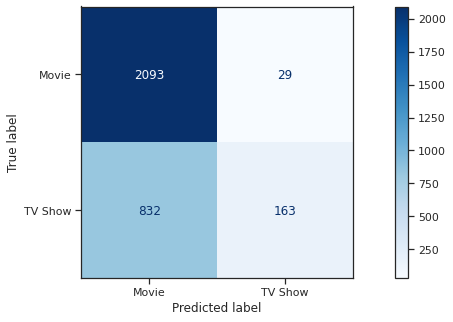

In [16]:
sentiment(TfidfVectorizer(), BernoulliNB())

## Вывод:
Наилучший результат показал классификатор LogisticRegression (точность определения класса movie 99%), а худший - метод К соседей с 4 соседями (92%).
Среди Байесовских классификаторов лучшую точность показал CNB, так как он предназначен для классов с отсутствием баланса.